<a href="https://colab.research.google.com/github/anirudh-g/Msc-Data-science/blob/master/Chart_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#SETUP

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#7 classes: Area chart, Bar chart, Line Chart, pie chart, scatter plot. 100 images per class. 80/20 train/val split
train_dir = '/content/drive/My Drive/Colab Notebooks/charts/Train'
validation_dir = '/content/drive/My Drive/Colab Notebooks/charts/Validation'


#DATA PROCESSING

In [11]:
#List of all basic tunable parameters of the model - to be updated
img_width, img_height = 224, 224
nb_train_samples = 560
nb_validation_samples = 140
epochs = 50
batch_size = 16

In [12]:
#checking whether the rgb channel is first or last to feed the input shape accordingly
if K.image_data_format() == 'channels_first': 
    input_shape = (3, img_width, img_height) 
else: 
    input_shape = (img_width, img_height, 3) 

In [13]:
def noisy_generator(batches):
    for batch_x, batch_y in batches:
        sigma = np.random.exponential(0.15)
        noise = np.random.normal(scale=sigma, size=batch_x.shape)
        batch_noisy = np.clip(batch_x + noise, 0, 1)
        yield (batch_noisy, batch_y)

In [14]:
#Performing augmentation on image scaling, zoom and  so that the network has more training samples
train_datagen = ImageDataGenerator( 
	rescale=1. / 255, 
	shear_range=0.2, 
	zoom_range=0.2, 
	channel_shift_range=150.0,
	brightness_range=(0.6,0.9)) 

#Not having any augmentation apart from scaling as the validation data should resemble the real-world data as close as possible
val_datagen = ImageDataGenerator(rescale=1. / 255) 

train_generator = train_datagen.flow_from_directory( 
	train_dir, 
	target_size=(img_width, img_height), 
	batch_size=batch_size, 
	class_mode='categorical') 

validation_generator = val_datagen.flow_from_directory( 
	validation_dir, 
	target_size=(img_width, img_height), 
	batch_size=batch_size, 
	class_mode='categorical')

train_noisy = noisy_generator(train_generator)

Found 560 images belonging to 7 classes.
Found 140 images belonging to 7 classes.


In [15]:
sample_training_images, _ = next(train_noisy)

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

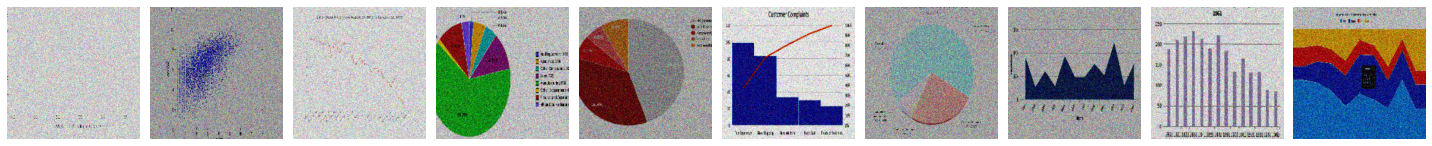

In [16]:
plotImages(sample_training_images[:10])

TRANSFER LEARNING

MOBILENETV2 - transfer learning

In [17]:
base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
base_model.summary()

9412608/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
________________

In [18]:
base_model.trainable=False

In [19]:
#top layer structure inspired from https://towardsdatascience.com/using-object-detection-for-complex-image-classification-scenarios-part-3-770d3fc5e3f7

top_layer = base_model.output
top_layer = GlobalAveragePooling2D()(top_layer)
top_layer = Dense(1024,activation='relu')(top_layer) #we add dense layers so that the model can learn more complex functions and classify for better results.
top_layer = Dense(1024,activation='relu')(top_layer) #dense layer 2
top_layer = Dense(512,activation='relu')(top_layer) #dense layer 3
prediction_layer = Dense(7,activation='softmax')(top_layer) #final layer with softmax activation

tl_model = keras.Model(inputs= base_model.input, outputs=prediction_layer)

In [20]:
lr =0.001
tl_model.compile(optimizer=tf.optimizers.Adam(learning_rate=lr),
              loss=tf.losses.categorical_crossentropy,
              metrics=['accuracy'])

In [21]:
len(tl_model.trainable_variables)

8

In [22]:
tl_history = tl_model.fit( 
	train_noisy,
	steps_per_epoch=nb_train_samples // batch_size, 
	epochs=epochs, 
	validation_data=validation_generator, 
	validation_steps=nb_validation_samples // batch_size) 


Epoch 1/50
35/35 [==============================] - 403s 12s/step - loss: 1.2089 - accuracy: 0.5839 - val_loss: 0.6672 - val_accuracy: 0.7578
Epoch 2/50
35/35 [==============================] - 18s 502ms/step - loss: 0.7455 - accuracy: 0.7304 - val_loss: 0.5274 - val_accuracy: 0.7812
Epoch 3/50
35/35 [==============================] - 17s 496ms/step - loss: 0.7132 - accuracy: 0.7732 - val_loss: 0.2996 - val_accuracy: 0.9062
Epoch 4/50
35/35 [==============================] - 17s 498ms/step - loss: 0.4728 - accuracy: 0.8411 - val_loss: 0.2081 - val_accuracy: 0.9141
Epoch 5/50
35/35 [==============================] - 17s 498ms/step - loss: 0.5456 - accuracy: 0.7786 - val_loss: 0.6511 - val_accuracy: 0.8281
Epoch 6/50
35/35 [==============================] - 18s 507ms/step - loss: 0.6172 - accuracy: 0.7679 - val_loss: 0.3577 - val_accuracy: 0.8906
Epoch 7/50
35/35 [==============================] - 18s 500ms/step - loss: 0.5255 - accuracy: 0.8018 - val_loss: 0.2828 - val_accuracy: 0.8984


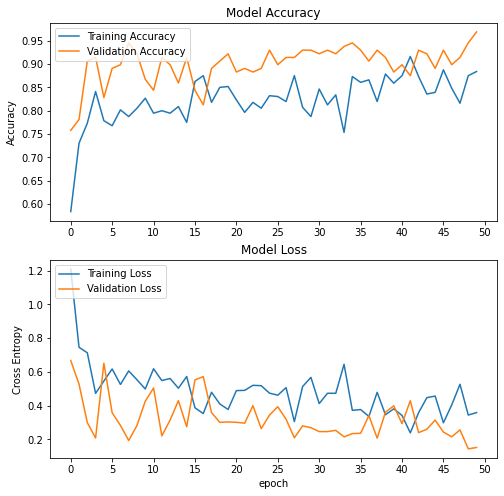

In [23]:
#Plot based on https://www.tensorflow.org/tutorials/images/transfer_learning

acc = tl_history.history['accuracy']
val_acc = tl_history.history['val_accuracy']

loss = tl_history.history['loss']
val_loss = tl_history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper left')
plt.ylabel('Accuracy')
plt.xticks(np.arange(0,55, 5))
plt.title('Model Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper left')
plt.ylabel('Cross Entropy')
plt.xticks(np.arange(0,55, 5))
plt.title('Model Loss')
plt.xlabel('epoch')
plt.show()

FINE TUNING

In [28]:
base_model.trainable = True

print("Number of layers in the base model: ", len(base_model.layers))

fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  155


In [29]:
tl_model.compile(optimizer=tf.optimizers.Adam(learning_rate=lr/10),
              loss=tf.losses.categorical_crossentropy,
              metrics=['accuracy'])

In [30]:
len(tl_model.trainable_variables)

64

In [31]:
fine_tune_epochs = 50
total_epochs =  50 + fine_tune_epochs

tl_history_fine = tl_model.fit( 
	train_noisy, 
	steps_per_epoch=nb_train_samples // batch_size, 
	epochs=total_epochs,
  initial_epoch= tl_history.epoch[-1], 
	validation_data=validation_generator, 
	validation_steps=nb_validation_samples // batch_size) 

Epoch 50/100
35/35 [==============================] - 19s 536ms/step - loss: 0.5161 - accuracy: 0.8429 - val_loss: 0.2267 - val_accuracy: 0.9531
Epoch 51/100
35/35 [==============================] - 18s 506ms/step - loss: 0.4338 - accuracy: 0.8536 - val_loss: 0.2070 - val_accuracy: 0.9453
Epoch 52/100
35/35 [==============================] - 18s 518ms/step - loss: 0.3986 - accuracy: 0.8714 - val_loss: 0.4154 - val_accuracy: 0.8750
Epoch 53/100
35/35 [==============================] - 18s 509ms/step - loss: 0.3733 - accuracy: 0.8750 - val_loss: 0.5184 - val_accuracy: 0.8359
Epoch 54/100
35/35 [==============================] - 18s 517ms/step - loss: 0.3417 - accuracy: 0.8679 - val_loss: 0.4552 - val_accuracy: 0.8594
Epoch 55/100
35/35 [==============================] - 18s 514ms/step - loss: 0.3218 - accuracy: 0.8768 - val_loss: 0.4531 - val_accuracy: 0.8750
Epoch 56/100
35/35 [==============================] - 18s 508ms/step - loss: 0.3353 - accuracy: 0.8893 - val_loss: 0.4124 - val_ac

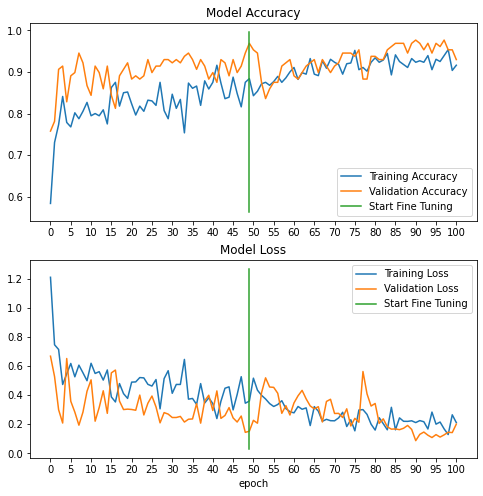

In [32]:
acc += tl_history_fine.history['accuracy']
val_acc += tl_history_fine.history['val_accuracy']
loss += tl_history_fine.history['loss']
val_loss += tl_history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xticks(np.arange(0,105, 5))
plt.plot([epochs-1,epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Model Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xticks(np.arange(0,105, 5))
plt.plot([epochs-1,epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Model Loss')
plt.xlabel('epoch')
plt.show()

VGG16 - transfer learning

In [33]:
vgg_base = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
vgg_base.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [34]:
vgg_base.trainable=False

In [35]:
vgg_top_layer = vgg_base.output
vgg_top_layer = GlobalAveragePooling2D()(vgg_top_layer)
vgg_top_layer = Dense(1024,activation='relu')(vgg_top_layer) #we add dense layers so that the model can learn more complex functions and classify for better results.
vgg_top_layer = Dense(1024,activation='relu')(vgg_top_layer) #dense layer 2
vgg_top_layer = Dense(512,activation='relu')(vgg_top_layer) #dense layer 3
vgg_prediction_layer = Dense(7,activation='softmax')(vgg_top_layer) #final layer with softmax activation

vgg_tl = keras.Model(inputs= vgg_base.input, outputs=vgg_prediction_layer)

In [36]:
lr=0.001
vgg_tl.compile(optimizer=tf.optimizers.Adam(learning_rate=lr),
              loss=tf.losses.categorical_crossentropy,
              metrics=['accuracy']) 

In [37]:
len(vgg_tl.trainable_variables)

8

In [38]:
vgg_history = vgg_tl.fit( 
	train_noisy, 
	steps_per_epoch=nb_train_samples // batch_size, 
	epochs=epochs, 
	validation_data=validation_generator, 
	validation_steps=nb_validation_samples // batch_size)

Epoch 1/50
35/35 [==============================] - 18s 520ms/step - loss: 1.5268 - accuracy: 0.4107 - val_loss: 0.9400 - val_accuracy: 0.5781
Epoch 2/50
35/35 [==============================] - 19s 529ms/step - loss: 0.8036 - accuracy: 0.6946 - val_loss: 0.7240 - val_accuracy: 0.6719
Epoch 3/50
35/35 [==============================] - 18s 525ms/step - loss: 0.6404 - accuracy: 0.7786 - val_loss: 0.3917 - val_accuracy: 0.8672
Epoch 4/50
35/35 [==============================] - 19s 538ms/step - loss: 0.8365 - accuracy: 0.6875 - val_loss: 0.3500 - val_accuracy: 0.8828
Epoch 5/50
35/35 [==============================] - 18s 524ms/step - loss: 0.6480 - accuracy: 0.7482 - val_loss: 0.3970 - val_accuracy: 0.8594
Epoch 6/50
35/35 [==============================] - 18s 521ms/step - loss: 0.5830 - accuracy: 0.7679 - val_loss: 0.2948 - val_accuracy: 0.9297
Epoch 7/50
35/35 [==============================] - 19s 540ms/step - loss: 0.4941 - accuracy: 0.7929 - val_loss: 0.3141 - val_accuracy: 0.9062

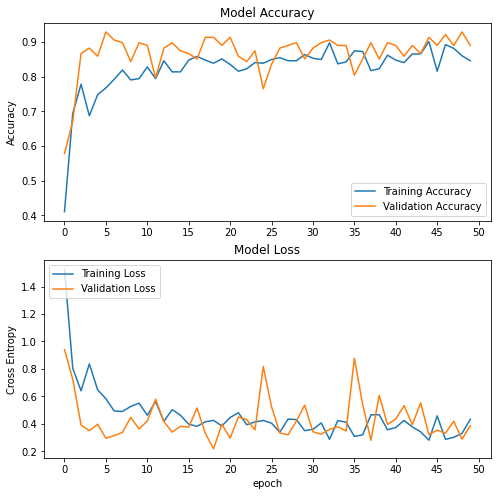

In [39]:
vgg_acc = vgg_history.history['accuracy']
vgg_val_acc = vgg_history.history['val_accuracy']

vgg_loss = vgg_history.history['loss']
vgg_val_loss = vgg_history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(vgg_acc, label='Training Accuracy')
plt.plot(vgg_val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.xticks(np.arange(0,55, 5))
plt.title('Model Accuracy')

plt.subplot(2, 1, 2)
plt.plot(vgg_loss, label='Training Loss')
plt.plot(vgg_val_loss, label='Validation Loss')
plt.legend(loc='upper left')
plt.ylabel('Cross Entropy')
plt.xticks(np.arange(0,55, 5))
plt.title('Model Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
vgg_base.trainable = True

print("Number of layers in the base model: ", len(vgg_base.layers))

fine_tune_at = 15

# Freeze all the layers before the `fine_tune_at` layer
for layer in vgg_base.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  19


In [ ]:
vgg_tl.compile(optimizer=tf.optimizers.Adam(learning_rate=lr/10),
              loss=tf.losses.categorical_crossentropy,
              metrics=['accuracy'])

In [ ]:
len(vgg_tl.trainable_variables)

14

In [ ]:
fine_tune_epochs = 50
total_epochs =  epochs + fine_tune_epochs

vgg_history_fine = vgg_tl.fit( 
	train_generator, 
	steps_per_epoch=nb_train_samples // batch_size, 
	epochs=total_epochs,
  initial_epoch= vgg_history.epoch[-1], 
	validation_data=validation_generator, 
	validation_steps=nb_validation_samples // batch_size) 

Epoch 50/100
35/35 [==============================] - 16s 445ms/step - loss: 0.8050 - accuracy: 0.8214 - val_loss: 0.1952 - val_accuracy: 0.9375
Epoch 51/100
35/35 [==============================] - 16s 456ms/step - loss: 0.3527 - accuracy: 0.8839 - val_loss: 0.6996 - val_accuracy: 0.8984
Epoch 52/100
35/35 [==============================] - 16s 443ms/step - loss: 0.2961 - accuracy: 0.9036 - val_loss: 0.3126 - val_accuracy: 0.9297
Epoch 53/100
35/35 [==============================] - 16s 448ms/step - loss: 0.2804 - accuracy: 0.8964 - val_loss: 0.2908 - val_accuracy: 0.9453
Epoch 54/100
35/35 [==============================] - 15s 441ms/step - loss: 0.2359 - accuracy: 0.9232 - val_loss: 0.2644 - val_accuracy: 0.9297
Epoch 55/100
35/35 [==============================] - 16s 444ms/step - loss: 0.2371 - accuracy: 0.9107 - val_loss: 0.2908 - val_accuracy: 0.9141
Epoch 56/100
35/35 [==============================] - 15s 439ms/step - loss: 0.1412 - accuracy: 0.9571 - val_loss: 0.3168 - val_ac

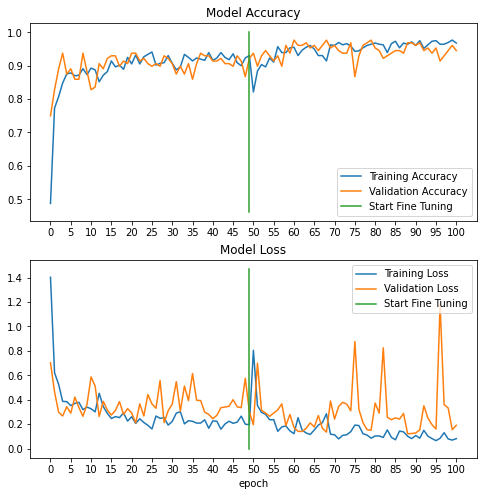

In [ ]:
vgg_acc += vgg_history_fine.history['accuracy']
vgg_val_acc += vgg_history_fine.history['val_accuracy']
vgg_loss += vgg_history_fine.history['loss']
vgg_val_loss += vgg_history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(vgg_acc, label='Training Accuracy')
plt.plot(vgg_val_acc, label='Validation Accuracy')
plt.xticks(np.arange(0,105, 5))
plt.plot([epochs-1,epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Model Accuracy')

plt.subplot(2, 1, 2)
plt.plot(vgg_loss, label='Training Loss')
plt.plot(vgg_val_loss, label='Validation Loss')
plt.xticks(np.arange(0,105, 5))
plt.plot([epochs-1,epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Model Loss')
plt.xlabel('epoch')
plt.show()